### Load and preprocess the dataset

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMAGE_SIZE = 224  # larger size = more detail but also more computation and memory usage
HORIZONTAL_FLIP_PROB = 0.5  # Probability of flipping images horizontally during training (useful for symmetrical objects).
BATCH_SIZE = 16  # 32 Number of samples processed in each batch (higher value speeds up training but requires more memory).
NUM_WORKERS = 4  # Number of CPU workers for data loading (increasing improves speed on machines with multiple cores).

# Mean and standard deviation for normalization
MEAN = [0.485, 0.456, 0.406]  # default for ImageNet pre-trained models
STD = [0.229, 0.224, 0.225]  # default for ImageNet pre-trained models

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize imgs to match ResNet input
        transforms.RandomHorizontalFlip(p=HORIZONTAL_FLIP_PROB),  # Apply horizontal flip with specified probability
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize(MEAN, STD)  # Normalize using the specified mean and std
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize for validation
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize(MEAN, STD)  # Normalize using the specified mean and std
    ]),
}

# Load dataset
DATA_DIR = r'D:\Bowerbird-ID\5_Split_train_val_sets\Dataset'  
datasets = {
    phase: datasets.ImageFolder(os.path.join(DATA_DIR, phase), transform=data_transforms[phase])
    for phase in ['train', 'val']
}

# Create data loaders
dataloaders = {
    phase: DataLoader(datasets[phase], batch_size=BATCH_SIZE, shuffle=(phase == 'train'), num_workers=NUM_WORKERS)
    for phase in ['train', 'val']
}

dataset_sizes = {phase: len(datasets[phase]) for phase in ['train', 'val']}
class_names = datasets['train'].classes

print(f"Classes: {class_names}")
print(f"Training samples: {dataset_sizes['train']}, Validation samples: {dataset_sizes['val']}")


Classes: ['B02', 'B03', 'B04', 'B05', 'B07', 'B11', 'B18', 'B23', 'B26', 'B29', 'B30', 'B31', 'B47', 'B49', 'B50', 'B52']
Training samples: 1268, Validation samples: 555


### Load pre trained ResNet50

In [2]:
import torch
from torchvision import models

NUM_CLASSES = 16
USE_PRETRAINED = True  # using a pre-trained ResNet50 as it is supposed to speed up training and improve accuracy 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # knows to fallback to cpu if there is no gpu

model = models.resnet50(pretrained=USE_PRETRAINED)  # uses pre-trained weights

# classifier head
num_ftrs = model.fc.in_features  # extracts the number of input features to the classifier layer
model.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)  # custom layer
model = model.to(device)

c:\Users\Athena\miniconda3\envs\bowerbird\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Athena\miniconda3\envs\bowerbird\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Define training pipeline and train the model!

Epoch 1/50
----------
train Loss: 2.5199 Acc: 0.2137
val Loss: 2.0641 Acc: 0.3622
Epoch 2/50
----------
train Loss: 1.6600 Acc: 0.5371
val Loss: 1.5694 Acc: 0.5297
Epoch 3/50
----------
train Loss: 1.0613 Acc: 0.7027
val Loss: 1.1673 Acc: 0.6559
Epoch 4/50
----------
train Loss: 0.6559 Acc: 0.8368
val Loss: 1.0242 Acc: 0.6973
Epoch 5/50
----------
train Loss: 0.4064 Acc: 0.8991
val Loss: 0.8553 Acc: 0.7514
Epoch 6/50
----------
train Loss: 0.2215 Acc: 0.9558
val Loss: 0.8382 Acc: 0.7423
Epoch 7/50
----------
train Loss: 0.1592 Acc: 0.9748
val Loss: 0.7470 Acc: 0.7730
Epoch 8/50
----------
train Loss: 0.1002 Acc: 0.9890
val Loss: 0.6573 Acc: 0.8000
Epoch 9/50
----------
train Loss: 0.0829 Acc: 0.9937
val Loss: 0.6417 Acc: 0.7982
Epoch 10/50
----------
train Loss: 0.0768 Acc: 0.9945
val Loss: 0.6566 Acc: 0.7928
Epoch 11/50
----------
train Loss: 0.0695 Acc: 0.9929
val Loss: 0.6247 Acc: 0.8108
Epoch 12/50
----------
train Loss: 0.0611 Acc: 0.9976
val Loss: 0.6295 Acc: 0.8090
Epoch 13/50
-

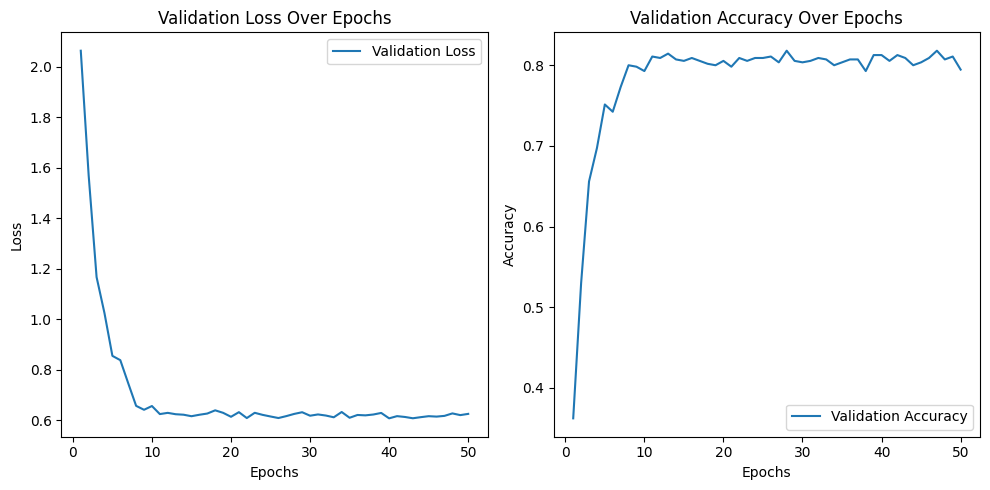

In [3]:
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import matplotlib.pyplot as plt
import os

NUM_EPOCHS = 50  # defines learning time. Too many risks overfitting
LEARNING_RATE = 0.001  # decreasing it slows learning but can improve stability
MOMENTUM = 0.9  # momentum for SGD; helps in faster convergence by damping oscillations
STEP_SIZE = 7  # reduces learning rate every X epochs
GAMMA = 0.1  # Multiplicative factor for learning rate decay... lower values decrease the rate more aggressively

# Loss function
criterion = torch.nn.CrossEntropyLoss()  # Standard for multi-class classification

# Optimiser
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    val_losses = []
    val_accuracies = []

    # Directory to save the best model
    model_save_path = os.path.join(os.getcwd(), "best_model.pth")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'): # Forward pass
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train': # Backward pass + optimize only during training 
                        loss.backward()
                        optimizer.step()

                # Track stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

                # Save the best model weights
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    torch.save(best_model_wts, model_save_path)  # Save best model

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    print(f'Best model saved at: {model_save_path}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot validation loss and accuracy graphs
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10, 5))

    # Loss graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Validation Loss Over Epochs")
    plt.legend()

    # Accuracy graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Actual training of the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)


Model evaluation: Confusion matrix and classification report

Classification report:
              precision    recall  f1-score   support

         B02       0.62      0.62      0.62        37
         B03       0.81      0.72      0.76        29
         B04       0.65      0.65      0.65        17
         B05       0.82      0.80      0.81        35
         B07       0.98      0.95      0.97        44
         B11       0.69      0.88      0.78        43
         B18       0.90      0.86      0.88        42
         B23       0.74      0.76      0.75        45
         B26       0.89      0.97      0.93        33
         B29       0.75      0.70      0.72        30
         B30       0.47      0.37      0.41        19
         B31       0.54      0.67      0.60        21
         B47       0.79      0.70      0.74        37
         B49       0.89      0.93      0.91        44
         B50       0.92      0.77      0.84        31
         B52       0.91      0.90      0.91        48

    accuracy                           0.79       555
   

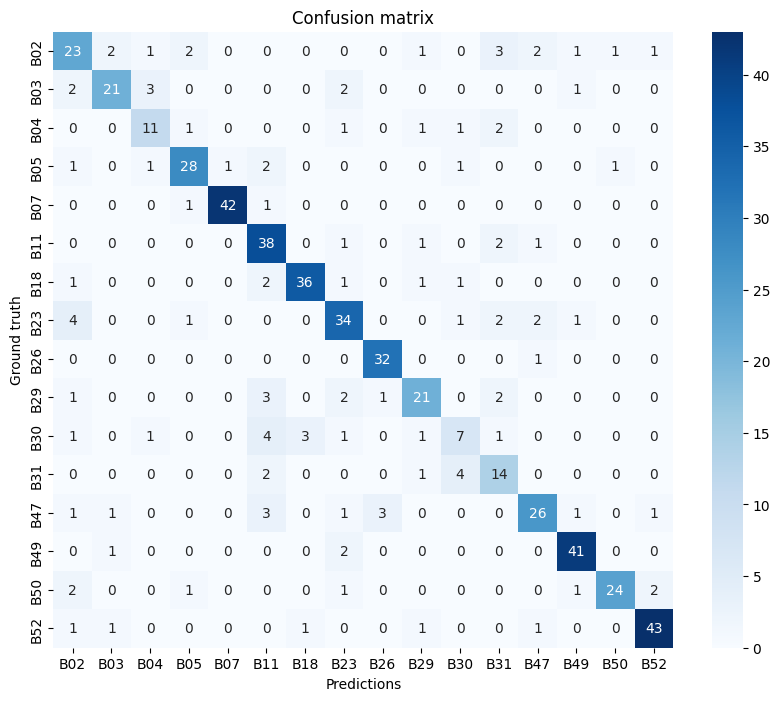

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

EVAL_BATCH_SIZE = 16 # Batch size for val

val_loader = dataloaders['val']

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
print("Classification report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predictions")
plt.ylabel("Ground truth")
plt.title("Confusion matrix")
plt.show()